# Head

In [113]:
import sys
sys.path.append("projects/periodical-clustering")

from utils import get_data_dir, Scopus2abbr, Scopus2color

In [114]:
import os

import pandas as pd
import numpy as np
from scipy.optimize import linear_sum_assignment

from matplotlib import pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns

In [115]:
df = pd.read_parquet(os.path.join(get_data_dir(), '2010s/clustering_results/cluster_df.parquet'), 
                     columns=['Scopus_label', 'x_val', 'y_val', 'kmeans_label'])
df

data_dir:  /home/zqlyu2/projects/periodical-clustering/data


,Scopus_label,x_val,y_val,kmeans_label
202381698,Multidisciplinary,-67.928200,15.572327,17
137773608,Multidisciplinary,-68.405334,-55.633186,17
125754415,Multidisciplinary,-68.448853,-55.613579,17
3880285,Multidisciplinary,-68.407288,-55.634430,8
111155417,Chemistry,-54.506985,-61.217068,11
...,...,...,...,...
2764485818,Medicine,-28.969574,34.819569,18
83454320,Arts and Humanities,78.609909,31.736822,13
16507453,Arts and Humanities,89.206772,17.625090,13
121509672,Agricultural and Biological Sciences,-36.757057,-0.591017,21


# Hungarian match

In [116]:
def match_labels_hungarian(df, label_type='kmeans_label'):
    # Create a contingency table
    contingency = pd.crosstab(df[label_type], df['Scopus_label'])
    contingency.drop(columns=['Multidisciplinary'], inplace=True)
    
    # Convert to cost matrix (negative because we want to maximize the overlap)
    cost_matrix = -contingency.values
    
    # Apply Hungarian algorithm
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Create mapping from kmeans labels to Scopus labels
    cluster2Scopus = {
        contingency.index[i]: contingency.columns[j]
        for i, j in zip(row_ind, col_ind)
    }
    
    # Create a new column with matched Scopus labels
    df_matched = df.copy()
    df_matched['matched_Scopus'] = df[label_type].map(cluster2Scopus)
    
    # Calculate accuracy
    accuracy = (df_matched['matched_Scopus'] == df_matched['Scopus_label']).mean()
    
    # Print results
    print(f"Matching accuracy: {accuracy:.4f}")
    
    # Return the mapping and matched dataframe
    return cluster2Scopus, df_matched

In [117]:
cluster2Scopus, df_matched = match_labels_hungarian(df)
print(Scopus2abbr.keys() - cluster2Scopus.values())
df_matched

Matching accuracy: 0.4326
{'Multidisciplinary'}


,Scopus_label,x_val,y_val,kmeans_label,matched_Scopus
202381698,Multidisciplinary,-67.928200,15.572327,17,"Biochemistry, Genetics and Molecular Biology"
137773608,Multidisciplinary,-68.405334,-55.633186,17,"Biochemistry, Genetics and Molecular Biology"
125754415,Multidisciplinary,-68.448853,-55.613579,17,"Biochemistry, Genetics and Molecular Biology"
3880285,Multidisciplinary,-68.407288,-55.634430,8,Agricultural and Biological Sciences
111155417,Chemistry,-54.506985,-61.217068,11,Chemistry
...,...,...,...,...,...
2764485818,Medicine,-28.969574,34.819569,18,"Pharmacology, Toxicology and Pharmaceutics"
83454320,Arts and Humanities,78.609909,31.736822,13,Arts and Humanities
16507453,Arts and Humanities,89.206772,17.625090,13,Arts and Humanities
121509672,Agricultural and Biological Sciences,-36.757057,-0.591017,21,Immunology and Microbiology


In [118]:
cluster2Scopus

{0: 'Economics, Econometrics and Finance',
 1: 'Environmental Science',
 2: 'Computer Science',
 3: 'Dentistry',
 4: 'Neuroscience',
 5: 'Energy',
 6: 'Physics and Astronomy',
 7: 'Medicine',
 8: 'Agricultural and Biological Sciences',
 9: 'Psychology',
 10: 'Materials Science',
 11: 'Chemistry',
 12: 'Earth and Planetary Sciences',
 13: 'Arts and Humanities',
 14: 'Engineering',
 15: 'Mathematics',
 16: 'Veterinary',
 17: 'Biochemistry, Genetics and Molecular Biology',
 18: 'Pharmacology, Toxicology and Pharmaceutics',
 19: 'Chemical Engineering',
 20: 'Nursing',
 21: 'Immunology and Microbiology',
 22: 'Health Professions',
 23: 'Decision Sciences',
 24: 'Business, Management and Accounting',
 25: 'Social Sciences'}

In [320]:
Scopus2cluster = {v: k for k, v in cluster2Scopus.items()}
Scopus2cluster

{'Economics, Econometrics and Finance': 0,
 'Environmental Science': 1,
 'Computer Science': 2,
 'Dentistry': 3,
 'Neuroscience': 4,
 'Energy': 5,
 'Physics and Astronomy': 6,
 'Medicine': 7,
 'Agricultural and Biological Sciences': 8,
 'Psychology': 9,
 'Materials Science': 10,
 'Chemistry': 11,
 'Earth and Planetary Sciences': 12,
 'Arts and Humanities': 13,
 'Engineering': 14,
 'Mathematics': 15,
 'Veterinary': 16,
 'Biochemistry, Genetics and Molecular Biology': 17,
 'Pharmacology, Toxicology and Pharmaceutics': 18,
 'Chemical Engineering': 19,
 'Nursing': 20,
 'Immunology and Microbiology': 21,
 'Health Professions': 22,
 'Decision Sciences': 23,
 'Business, Management and Accounting': 24,
 'Social Sciences': 25}

# Clusim score

In [119]:
from clusim.clustering import Clustering
import clusim.sim as sim

df_matched.reset_index(names=['VID'], inplace=True)
# Key: row index, val: value of 'area' column
dict_original = {index: [row['Scopus_label']] for index, row in df_matched.iterrows()}
# Key: row index, val: value of 'cluster_label' column
dict_clustering = {index: [row['kmeans_label']] for index, row in df_matched.iterrows()}

c_original = Clustering(elm2clu_dict = dict_original)
c_clustering = Clustering(elm2clu_dict = dict_clustering)

elementScores, relabeled_elements = sim.element_sim_elscore(c_original, c_clustering, alpha = 0.9)
df_matched['sim_score'] = elementScores
df_matched.set_index('VID', inplace=True)
df_matched

,Scopus_label,x_val,y_val,kmeans_label,matched_Scopus,sim_score
VID,,,,,,
202381698,Multidisciplinary,-67.928200,15.572327,17,"Biochemistry, Genetics and Molecular Biology",0.003915
137773608,Multidisciplinary,-68.405334,-55.633186,17,"Biochemistry, Genetics and Molecular Biology",0.003915
125754415,Multidisciplinary,-68.448853,-55.613579,17,"Biochemistry, Genetics and Molecular Biology",0.003915
3880285,Multidisciplinary,-68.407288,-55.634430,8,Agricultural and Biological Sciences,0.009864
111155417,Chemistry,-54.506985,-61.217068,11,Chemistry,0.355841
...,...,...,...,...,...,...
2764485818,Medicine,-28.969574,34.819569,18,"Pharmacology, Toxicology and Pharmaceutics",0.094303
83454320,Arts and Humanities,78.609909,31.736822,13,Arts and Humanities,0.709161
16507453,Arts and Humanities,89.206772,17.625090,13,Arts and Humanities,0.709161


# IDW

In [380]:
def make_grid(resolution, xlim, ylim):
    X_vals = np.linspace(xlim[0], xlim[1], resolution)
    Y_vals = np.linspace(ylim[0], ylim[1], resolution)
    X_mesh, Y_mesh = np.meshgrid(X_vals, Y_vals)
    X_mesh = X_mesh.flatten()
    Y_mesh = Y_mesh.flatten()

    print('num of coords:', X_mesh.shape)
    return X_mesh, Y_mesh

def distance_matrix(x0, y0, x1, y1):
    """ 
    Make a distance matrix between pairwise observations.
    Note: from <http://stackoverflow.com/questions/1871536> 
    """
    
    obs = np.vstack((x0, y0)).T
    interp = np.vstack((x1, y1)).T

    d0 = np.subtract.outer(obs[:,0], interp[:,0])
    d1 = np.subtract.outer(obs[:,1], interp[:,1])
    
    # calculate hypotenuse
    return np.hypot(d0, d1)

def simple_idw(x, y, z, xi, yi, power=1):
    """ 
    Simple inverse distance weighted (IDW) interpolation 
    Weights are proportional to the inverse of the distance, so as the distance
    increases, the weights decrease rapidly.
    The rate at which the weights decrease is dependent on the value of power.
    As power increases, the weights for distant points decrease rapidly.
    """
    
    dist = distance_matrix(x,y, xi,yi)
    # In IDW, weights are 1 / distance
    weights = 1.0/(dist+1e-12)**power
    # Make weights sum to one
    weights /= weights.sum(axis=0)

    # Multiply the weights for each interpolated point by all observed Z-values
    return np.dot(weights.T, z)


xlim, ylim = df_matched[['x_val', 'y_val']].agg(['min', 'max']).values.T
offset = 10
xlim = (xlim[0] - offset, xlim[1] + offset)
ylim = (ylim[0] - offset, ylim[1] + offset)
print('xlim:', xlim, 'ylim:', ylim)
X_mesh, Y_mesh = make_grid(128, xlim, ylim)
pred_z = simple_idw(df_matched["x_val"], df_matched["y_val"], df_matched["sim_score"], X_mesh, Y_mesh, power=2)
print(pred_z.min(), pred_z.mean(), pred_z.max())

xlim: (-109.72663879394531, 110.62762451171875) ylim: (-112.1141128540039, 111.40674591064453)
num of coords: (16384,)
0.02787486110554543 0.2710648741905333 0.8272241815623617


# Plot

In [121]:
df_matched = df_matched.merge(pd.read_parquet(os.path.join(get_data_dir(), 'MAG_venue.parquet'))['OriginalVenue'], left_index=True, right_index=True).rename(columns={'OriginalVenue': 'venue_name'})
df_matched

data_dir:  /home/zqlyu2/projects/periodical-clustering/data


,Scopus_label,x_val,y_val,kmeans_label,matched_Scopus,sim_score,venue_name
VID,,,,,,,
202381698,Multidisciplinary,-67.928200,15.572327,17,"Biochemistry, Genetics and Molecular Biology",0.003915,PLOS ONE
137773608,Multidisciplinary,-68.405334,-55.633186,17,"Biochemistry, Genetics and Molecular Biology",0.003915,Nature
125754415,Multidisciplinary,-68.448853,-55.613579,17,"Biochemistry, Genetics and Molecular Biology",0.003915,Proceedings of the National Academy of Science...
3880285,Multidisciplinary,-68.407288,-55.634430,8,Agricultural and Biological Sciences,0.009864,Science
111155417,Chemistry,-54.506985,-61.217068,11,Chemistry,0.355841,Journal of the American Chemical Society
...,...,...,...,...,...,...,...
2764485818,Medicine,-28.969574,34.819569,18,"Pharmacology, Toxicology and Pharmaceutics",0.094303,The internet journal of the third world medicine
83454320,Arts and Humanities,78.609909,31.736822,13,Arts and Humanities,0.709161,Publications of The English Goethe Society
16507453,Arts and Humanities,89.206772,17.625090,13,Arts and Humanities,0.709161,Peritia


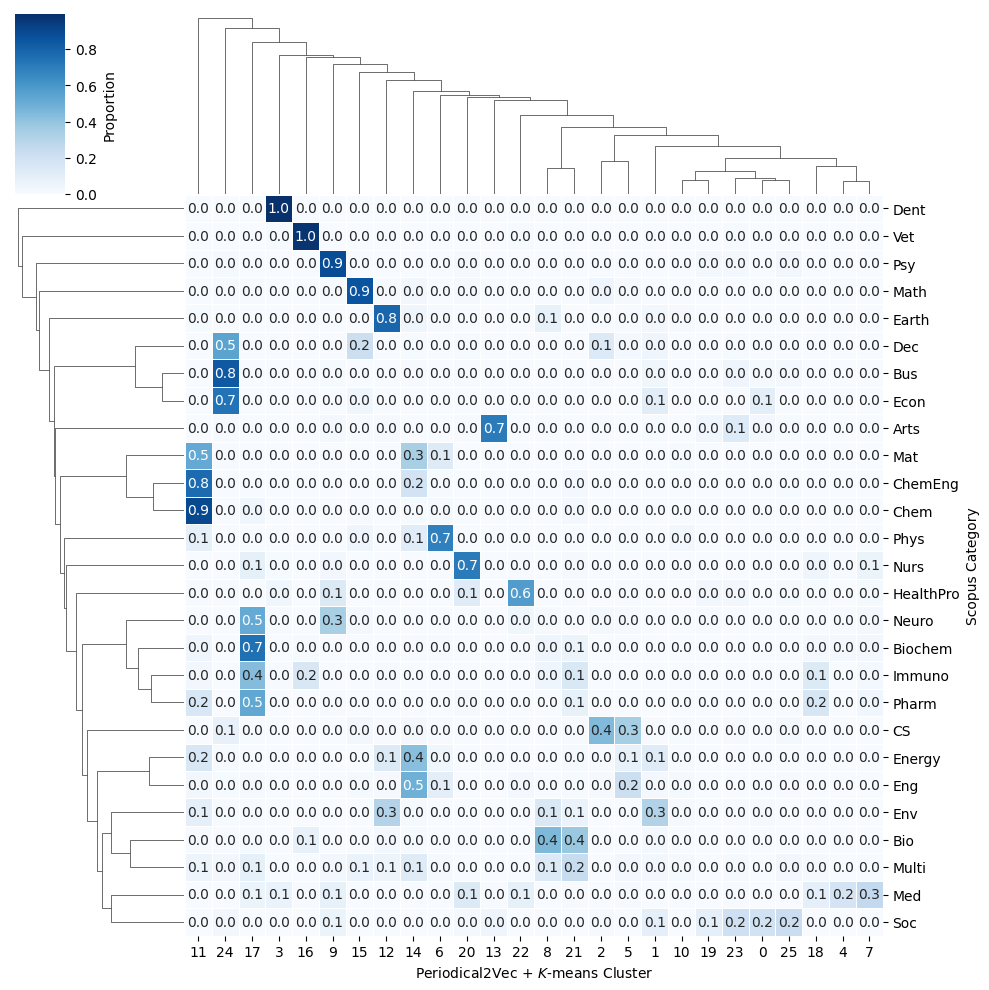

In [302]:
# Create a heatmap showing the confusion matrix normalized by rows
crosstab = pd.crosstab(df_matched['Scopus_label'], df_matched['kmeans_label'], normalize='index')

# Use abbreviated labels for better readability
crosstab.index = crosstab.index.map(lambda x: Scopus2abbr.get(x, x))

# Use the same color scheme as in other plots
cmap = sns.color_palette("Blues", as_cmap=True)

# Create the clustermap with improved formatting
g = sns.clustermap(
    crosstab,
    annot=True, 
    linewidth=.5,
    fmt=".1f",
    cmap=cmap,
    cbar_kws={'label': 'Proportion'},
    figsize=(10, 10)
)

g.ax_heatmap.set_xlabel('Periodical2Vec + $K$-means Cluster')
g.ax_heatmap.set_ylabel('Scopus Category')

plt.show()
g.savefig('projects/periodical-clustering/structure/heatmap.pdf', dpi=300)

<Figure size 640x480 with 0 Axes>

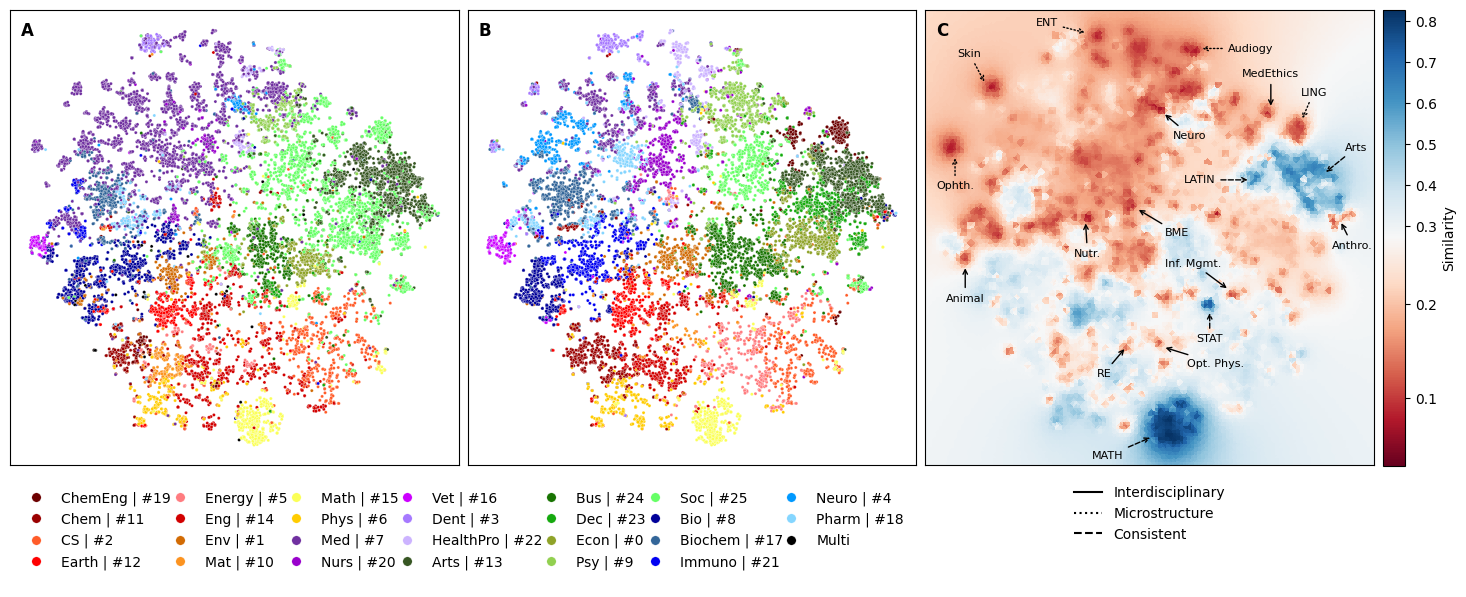

In [495]:
import matplotlib

fig = plt.figure(layout='constrained')
fig, axes = plt.subplots(2, 4, figsize=(18, 7.5), gridspec_kw={'width_ratios': [1, 1, 1, 0.05], 'height_ratios': [1, 0.25]})
plt.subplots_adjust(wspace=0.025, hspace=0.025)
axes = axes.flatten()

##############################################################################
# First plot (Scopus labels)
scatter = sns.scatterplot(data=df, x='x_val', y='y_val', 
                          hue='Scopus_label', palette=Scopus2color, s=5,
                          ax=axes[0])
axes[0].set_aspect('equal')
axes[0].set_xlim(xlim)
axes[0].set_ylim(ylim)
axes[0].legend().set_visible(False)
axes[0].text(0.025, 0.975, 'A', transform = axes[0].transAxes, 
             fontsize=12, fontweight='bold', va='top', ha='left')

##############################################################################
# Second plot (matched Scopus labels)
sns.scatterplot(data=df_matched, x='x_val', y='y_val', 
                          hue='matched_Scopus', palette=Scopus2color, s=5,
                          ax=axes[1])
axes[1].set_aspect('equal')
axes[1].set_xlim(xlim)
axes[1].set_ylim(ylim)
axes[1].legend().set_visible(False)
axes[1].text(0.025, 0.975,'B', transform = axes[1].transAxes, 
             fontsize=12, fontweight='bold', va='top', ha='left')

##############################################################################
# Third plot (similarity between KMeans label and Scopus label)
axes[2].set_aspect('equal')
axes[2].set_xlim(xlim)
axes[2].set_ylim(ylim)
cmap = plt.get_cmap('RdBu')     
# use TwoSlopeNorm to ensure 0 is mapped to the neutral color in the cmap
norm = TwoSlopeNorm(vcenter=pred_z.mean(), vmin=pred_z.min(), vmax=pred_z.max())

cs = axes[2].tripcolor(X_mesh, Y_mesh, pred_z, cmap=cmap, norm=norm)
axes[2].annotate("BME", (-6, 14), xytext=(14, 2), fontsize=8, ha='center', va='center',
                 arrowprops=dict(arrowstyle="->"))
axes[2].annotate("Inf. Mgmt.", (39.5, -26), xytext=(22, -13), ha='center', va='center',
                 fontsize=8, arrowprops=dict(arrowstyle="->"))
axes[2].annotate("RE", (-11, -54), xytext=(-22, -67), ha='center', va='center',
                 fontsize=8, arrowprops=dict(arrowstyle="->"))
axes[2].annotate('Opt. Phys.', (7, -54), xytext=(33, -62), ha='center', va='center',
                 fontsize=8, arrowprops=dict(arrowstyle="->"))
axes[2].annotate('Nutr.', (-31, 8), xytext=(-30, -8), ha='center', va='center',
                 fontsize=8, arrowprops=dict(arrowstyle="->"))
axes[2].annotate('Neuro', (7, 61), xytext=(20, 50), ha='center', va='center',
                 fontsize=8, arrowprops=dict(arrowstyle="->"))
axes[2].annotate('Animal', (-90, -14), xytext=(-90, -30), ha='center', va='center',
                 fontsize=8, arrowprops=dict(arrowstyle="->"))
axes[2].annotate('MedEthics', (60, 63), xytext=(60, 80), ha='center', va='center',
                 fontsize=8, arrowprops=dict(arrowstyle="->"))
axes[2].annotate('Anthro.', (94, 8), xytext=(100, -4), ha='center', va='center',
                 fontsize=8, arrowprops=dict(arrowstyle="->"))
                 
axes[2].annotate("Ophth.", (-95, 40), xytext=(-95, 25), ha='center', va='center',
                 fontsize=8, arrowprops=dict(arrowstyle="->", linestyle=':'))
axes[2].annotate("Skin", (-80, 75), xytext=(-88, 90), ha='center', va='center',
                 fontsize=8, arrowprops=dict(arrowstyle="->", linestyle=':'))
axes[2].annotate("Audiogy", (25, 92.5), xytext=(50, 92.5), ha='center', va='center',
                 fontsize=8, arrowprops=dict(arrowstyle="->", linestyle=':'))
axes[2].annotate("ENT", (-30, 100), xytext=(-50, 105), ha='center', va='center',
                 fontsize=8, arrowprops=dict(arrowstyle="->", linestyle=':'))
axes[2].annotate("LING", (75, 57), xytext=(81, 71), ha='center', va='center',
                 fontsize=8, arrowprops=dict(arrowstyle="->", linestyle=':'))

axes[2].annotate("MATH", (2, -98), xytext=(-20, -107.5), ha='center', va='center',
                 fontsize=8, arrowprops=dict(arrowstyle="->", linestyle='--'))
axes[2].annotate("STAT", (30, -36), xytext=(30, -50), ha='center', va='center',
                 fontsize=8, arrowprops=dict(arrowstyle="->", linestyle='--'))
axes[2].annotate("LATIN", (50, 28), xytext=(25, 28), ha='center', va='center',
                 fontsize=8, arrowprops=dict(arrowstyle="->", linestyle='--'))
axes[2].annotate("Arts", (86, 31), xytext=(102, 44), ha='center', va='center',
                 fontsize=8, arrowprops=dict(arrowstyle="->", linestyle='--'))

axes[2].text(0.025, 0.975, 'C', transform = axes[2].transAxes, 
             fontsize=12, fontweight='bold', va='top', ha='left')

##############################################################################
# Fourth plot (colorbar)
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
# sm.set_array([])
plt.colorbar(sm, label="Similarity", cax=axes[3], orientation='vertical')

##############################################################################
# Fifth plot (legend)
ax_legend = plt.subplot2grid((2, 4), (1, 0), colspan=2)

# Get all the Scopus labels in the desired order
ordered_labels = list(Scopus2color.keys())
# Create a dictionary that maps labels to handles
handles, labels = scatter.get_legend_handles_labels()
label_to_handle = dict(zip(labels, handles))
# Create ordered lists of handles and abbreviated labels
ordered_handles = [label_to_handle.get(label, None) for label in ordered_labels if label in label_to_handle]
ordered_mapped_labels = [Scopus2abbr[label]+' | #'+ str(Scopus2cluster[label]) if label != 'Multidisciplinary' else 'Multi' for label in ordered_labels]

ax_legend.legend(ordered_handles, ordered_mapped_labels, 
                 loc='center', ncol=7, frameon=False, markerscale=3, mode='expand')

##############################################################################
# Fifth plot (legend)
# Create the legend for the dashed/solid lines in plot C
ax_legend_lines = axes[-2]

# Create custom lines for the legend
solid_line = matplotlib.lines.Line2D([0], [0], color='black', linestyle='-', 
                                    label='Interdisciplinary')
dashed_line = matplotlib.lines.Line2D([0], [0], color='black', linestyle=':', 
                                    label='Microstructure')
dotted_line = matplotlib.lines.Line2D([0], [0], color='black', linestyle='--', 
                                    label='Consistent')

# Add legend
ax_legend_lines.legend(handles=[solid_line, dashed_line, dotted_line], 
                      loc='upper center', frameon=False)

##############################################################################
# Hide axes
for ax in axes:
    if ax in [axes[3]]:
        continue
    else:
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticks([])
        ax.set_yticks([])
    if ax in [axes[0], axes[1], axes[2], axes[3]]:
        continue
    else:
        ax.set_axis_off()

ax_legend.set_axis_off()

# Add grid to subplots A, B, and C
# grid_kwargs = {'color': 'gray', 'linestyle': ':', 'alpha': 0.8}
# for i in range(3):
#     axes[i].set_xticks(np.arange(-100, 101, 20))
#     axes[i].set_yticks(np.arange(-100, 101, 20))
#     axes[i].grid(True, **grid_kwargs)

plt.show()

In [501]:
fig.savefig('projects/periodical-clustering/structure/interdisciplinary.png', dpi=300, transparent=False)

In [454]:
pd.set_option('display.max_colwidth', None)
df_matched[(df_matched['x_val'] > 85) & (df_matched['x_val'] < 105) &
           (df_matched['y_val'] > 5) & (df_matched['y_val'] < 15)].sort_values('sim_score', ascending=True)[['Scopus_label', 'kmeans_label', 'sim_score', 'venue_name']].head(10)

,Scopus_label,kmeans_label,sim_score,venue_name
VID,,,,
5833240,Social Sciences,17,0.000614,Anthropological Science
2764719519,Arts and Humanities,3,0.000641,International Journal of Paleopathology
73464505,Medicine,8,0.001079,Mankind
63697840,Social Sciences,18,0.001842,Anthropologie
108000440,Social Sciences,18,0.001842,Anthropologischer Anzeiger
29114012,Arts and Humanities,11,0.002562,Restaurator-international Journal for The Preservation of Library and Archival Material
189009225,Arts and Humanities,11,0.002562,Journal of The Institute of Conservation
114377761,Arts and Humanities,11,0.002562,Journal of The American Institute for Conservation
136893510,Social Sciences,22,0.002763,Homo-journal of Comparative Human Biology


In [504]:
len(df)

20038

In [502]:
df_matched[df_matched.kmeans_label == 25]

,Scopus_label,x_val,y_val,kmeans_label,matched_Scopus,sim_score,venue_name
VID,,,,,,,
104917558,Social Sciences,22.196621,26.957523,25,Social Sciences,0.221676,Procedia - Social and Behavioral Sciences
204030396,Computer Science,83.324936,-6.171639,25,Social Sciences,0.018564,Computers in Human Behavior
2764408520,Social Sciences,42.342239,37.367386,25,Social Sciences,0.221676,The Qualitative Report
94618750,Social Sciences,30.474871,38.392628,25,Social Sciences,0.221676,Teaching and Teacher Education
105208853,Social Sciences,14.014512,23.035772,25,Social Sciences,0.221676,Journal of Chemical Education
...,...,...,...,...,...,...,...
34183902,Social Sciences,38.549263,57.700397,25,Social Sciences,0.221676,Indian Journal of Social Work
2764566316,Arts and Humanities,37.003529,41.039879,25,Social Sciences,0.010250,Journal of Christian Education
2737081042,Social Sciences,36.319321,24.186377,25,Social Sciences,0.221676,"Revista Iberoamericana sobre Calidad, Eficacia y Cambio en Educación"


In [186]:
df_matched.sort_values('sim_score').head(30)

,Scopus_label,x_val,y_val,kmeans_label,matched_Scopus,sim_score,venue_name
VID,,,,,,,
139641095,Medicine,-27.910023,-16.029427,12,Earth and Planetary Sciences,0.000216,Journal of Environmental Monitoring
2756327665,Medicine,-42.513313,18.900452,10,Materials Science,0.000216,China journal of Chinese materia medica
158472458,Social Sciences,-45.396751,98.735725,3,Dentistry,0.000307,European Journal of Dental Education
99901373,Social Sciences,-6.901806,-43.250523,10,Materials Science,0.000307,Journal of Transportation Systems Engineering ...
43434489,Social Sciences,-4.577538,37.485691,16,Veterinary,0.000307,Journal of Veterinary Medical Education
196862746,Medicine,6.801452,71.448174,15,Mathematics,0.000432,Biographical Memoirs of Fellows of the Royal S...
11693765,Medicine,7.008702,63.945457,15,Mathematics,0.000432,Nonlinear Biomedical Physics
69876307,Social Sciences,12.156970,52.363079,6,Physics and Astronomy,0.000614,Resonance
2764765636,Social Sciences,-43.459343,49.974892,7,Medicine,0.000614,Journal of investigative medicine high impact ...
